# Validation and application of condition-specific community (CoCo) models from metagenomics and metatranscriptomics data
## Preliminaries

In [1]:
import numpy as np
import pandas as pd
import cobra as cb
import micom as mc
from coco import coco as co
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, t
from modelling_functions import *

config = cb.Configuration()
config.solver = 'cplex'

Define functions

In [2]:
def parameter_exploration(deltas, gammas, tradeoffs, set_biogas, meta=True):
    """Compute microbial growth rates for a range of parameters.

    Args:
        deltas (numpy array): Parameter that controls the base bounds for each MAG model.
        gammas (numpy array): Parameter that controls the impact of gene expression on reaction bounds.
        tradeoffs (numpy array): Micom parameter that controls the cooperation level in the communities.
        set_biogas (bool): Whether to set the exchange rates for methane and carbon dioxide.
        meta (bool): Whether to test Coco or METRADE.

    Returns:
        pandas DataFrame: Growth rates for the community models.
        pandas DataFrame: Growth rates for the CoCo models.
        pandas Series: MAG abundances divided by sample.
        pandas Series: MAG replication rates divided by sample.
    """

    param_product_bound, delta_bound = cocoGEM_builder.get_param_range()
    combinations = np.array([c for c in itertools.product(deltas, gammas, tradeoffs)])
    param_products = np.array([i[0]*i[1] for i in combinations])
    combinations = list(map(tuple, combinations[param_products <= param_product_bound]))
    community_dict = {} # every element is a list of species for a condition
    exp_growth = []
    abundances = []
    base_df_list = []
    coco_df_list = []
    for s in sample_names:
        print(s)

        # Filter species
        species_names = list(abundance_table.index[multiomic_abundance_table[s] >= abundance_cutoff])
        abundances.append(list(abundance_table.loc[multiomic_abundance_table[s] >= abundance_cutoff, s]))
        community_dict[s] = species_names
        print(species_names)

        # Load community model
        com = mc.load_pickle(community_dir + s + '_' + str(abundance_cutoff) + '.pickle')
        print("Built a community with a total of {} reactions.".format(len(com.reactions)))
        print("Built a community with a total of {} metabolites.".format(len(com.metabolites)))

        # apply environmental constraints
        com = set_medium(com, s, medium_dict, media_table, BA_lb)
        com = set_biochemical_constraints(com, s, biochemistry_table, set_biogas)
        com = set_MAG_constraints(com)

        # simulations over delta, gamma and tradeoff
        base_growths = pd.DataFrame(index=species_names, columns=pd.MultiIndex.from_tuples(combinations))
        coco_growths = pd.DataFrame(index=species_names, columns=pd.MultiIndex.from_tuples(combinations))
        for t in tradeoffs:
            try:
                sol = com.cooperative_tradeoff(fraction=t, fluxes=False)
                for c in combinations:
                    if c[2] == t:
                        base_growths.loc[:, c] = list(sol.members.loc[species_names, 'growth_rate'])
            except:
                print('No solution')
        for c in combinations:
            with com as coco_com:
                print('delta = ' + str(c[0]) + ', gamma = ' + str(c[1]) + ', tradeoff = ' + str(c[2]))
                cocoGEM_builder.build(coco_com, s, c[0], c[1], meta)
                try:
                    sol = coco_com.cooperative_tradeoff(fraction = c[2], fluxes=False)
                    coco_growths.loc[:, c] = list(sol.members.loc[species_names, 'growth_rate'])
                except:
                    print('No solution')
        base_df_list.append(base_growths)
        coco_df_list.append(coco_growths)

        # Get experimental growth for considered species
        gr = [growth_table.loc[xv, s] if c else np.nan for c, xv in zip(pd.Series(species_names).isin(growth_table.index), species_names)]
        exp_growth.append(gr)
    print('Finished')

    # wrap up results
    base_growth = pd.concat(base_df_list, axis=0, keys=sample_names)
    coco_growth = pd.concat(coco_df_list, axis=0, keys=sample_names)
    abundances = pd.Series(np.hstack(abundances))
    exp_growth = pd.Series(np.hstack(exp_growth))
    return base_growth, coco_growth, abundances, exp_growth

In [4]:
def compute_fluxes(base_tradeoff, delta, gamma, coco_tradeoff, set_biogas, meta=True):
    
    community_dict = {} # every element is a list of species for a condition
    base_flux_df_list = []
    coco_flux_df_list = []
    base_exc_df_list = []
    coco_exc_df_list = []
    for s in sample_names:
        print(s)

        # Build community model
        com = mc.load_pickle(community_dir + s + '_' + str(abundance_cutoff) + '.pickle')
        species_names = list(com.taxonomy['id'])
        community_dict[s] = species_names
        excRxns = [e.id for e in com.exchanges]
        print(species_names)
        print("Built a community with a total of {} reactions.".format(len(com.reactions)))
        print("Built a community with a total of {} metabolites.".format(len(com.metabolites)))

        # apply environmental constraints
        com = set_medium(com, s, medium_dict, media_table, BA_lb)
        com = set_biochemical_constraints(com, s, biochemistry_table, set_biogas)
        com = set_MAG_constraints(com)
        
        # simulations
        print('--- Base ---')
        with com:
            try:
                print('first')
                sol = com.cooperative_tradeoff(fraction = base_tradeoff, fluxes=True, pfba=True)
            except: # relax the tradeoff
                try:
                    print('second')
                    sol = com.cooperative_tradeoff(fraction = base_tradeoff-0.01, fluxes=True, pfba=True)
                except: # starting with an easier computation helps the solver
                    print('third')
                    com = relax_MAG_constraints(com)
                    sol = com.cooperative_tradeoff(fraction = base_tradeoff-0.02, fluxes=True, pfba=True)
                    com = set_MAG_constraints(com)
                    sol = com.cooperative_tradeoff(fraction = base_tradeoff-0.02, fluxes=True, pfba=True)
            print(str(sol.objective_value))
            print(str(sol.growth_rate))
            base_flux_df_list.append(sol.fluxes.loc[species_names, :])
            base_exc_df_list.append(sol.fluxes.loc['medium', excRxns])

        print('--- CoCo ---')
        with com as coco_com:
            cocoGEM_builder.build(coco_com, s, delta, gamma, meta)
            try:
                print('first')
                coco_sol = coco_com.cooperative_tradeoff(fraction = coco_tradeoff, fluxes=True, pfba=True)
            except:
                try:
                    print('second')
                    coco_sol = coco_com.cooperative_tradeoff(fraction = coco_tradeoff-0.01, fluxes=True, pfba=True)
                except:
                    print('third')
                    coco_com = relax_MAG_constraints(coco_com)
                    coco_sol = coco_com.cooperative_tradeoff(fraction = coco_tradeoff-0.02, fluxes=True, pfba=True)
                    coco_com = set_MAG_constraints(coco_com)
                    coco_sol = coco_com.cooperative_tradeoff(fraction = coco_tradeoff-0.02, fluxes=True, pfba=True)
            print(str(coco_sol.objective_value))
            print(str(coco_sol.growth_rate))
            coco_flux_df_list.append(coco_sol.fluxes.loc[species_names, :])
            coco_exc_df_list.append(coco_sol.fluxes.loc['medium', excRxns])
    print('Finished')

    # wrap up
    base_fluxes = pd.concat(base_flux_df_list, axis=0, keys=sample_names)
    coco_fluxes = pd.concat(coco_flux_df_list, axis=0, keys=sample_names)
    base_exchanges = pd.DataFrame(base_exc_df_list, index=sample_names).T
    coco_exchanges = pd.DataFrame(coco_exc_df_list, index=sample_names).T
    return base_fluxes, coco_fluxes, base_exchanges, coco_exchanges

Set up paths and variables

In [5]:
model_dir = '../data/models/gapfilled_and_amended/'
community_dir = '../data/models/communities/'
abundance_path = '../data/MAG_coverage.tsv'
rna_dir = '../data/transcriptomes/normalised/'
media_path = '../data/media_db.tsv'
growth_path = '../data/MAG_replication_rate.csv'
biochemistry_path = '../data/biochemistry.csv'
results_dir = '../results/'
abundance_cutoff = 0.01

## Data preparation

Load the MAGS abundances

In [6]:
abundance_table = pd.read_table(abundance_path, index_col='Bin Id')
abundance_table = abundance_table.iloc[:, abundance_table.columns.str.contains('% community', regex=False)]
abundance_table.columns = abundance_table.columns.str.replace('.sorted: % community', '')
abundance_table.index = abundance_table.index.str.replace('.fasta', '')
sample_names = abundance_table.columns
MAG_names = abundance_table.index

Load the replication rates obtained with CoPTR

In [7]:
growth_table = pd.read_table(growth_path, index_col='log2(PTR):genome_id/sample_id', sep=',')
growth_table.index = growth_table.index.str.replace('.fasta', '')

Load the RNA counts and build a global RNA table

In [8]:
df_list = []
key_list = []
for m in MAG_names:
    counts = pd.read_table(rna_dir + m + '.csv', sep=',', index_col='Unnamed: 0')
    counts.index = counts.index.str.replace('.faa_', '__')
    df_list.append(counts)
    key_list.append(m)
rna_table = pd.concat(df_list, axis=0, keys=key_list)
rna_table.columns = sample_names

Sum RNA abundances

In [ ]:
rna_sum_table = pd.DataFrame(index=MAG_names, columns=sample_names)
for s in sample_names:
    count_sums = rna_table[s].sum(axis=0, level=0)
    rna_sum_table.loc[:, s] = np.log(count_sums)
rna_sum_table = rna_sum_table.divide(rna_sum_table.sum(axis=0))

Combine nucleic acid abundances

In [ ]:
multiomic_abundance_table = np.multiply(abundance_table, rna_sum_table)
multiomic_abundance_table = multiomic_abundance_table.divide(multiomic_abundance_table.sum(axis=0))

Select the MAGs above the abundance threshold

In [9]:
MAG_names = []
for s in sample_names:
    MAG_names.extend(list(abundance_table.index[multiomic_abundance_table[s] >= abundance_cutoff]))
MAG_names = np.unique(MAG_names)
# Subset RNA tables
rna_table = rna_table.loc[MAG_names, :]

Prepare the media

In [10]:
media_table = pd.read_table(media_path, sep='\t')
media_table['exchange_reaction'] = 'EX_' + media_table['compound'] + '_e_m'
medium_dict = dict(zip(sample_names, np.repeat(['BA[acetate]', 'BA[acetate+H2]', 'BA[acetate+H2]'], 3)))

Load the biochemical data

In [11]:
biochemistry_table = pd.read_table(biochemistry_path, index_col='met', sep=',')
biochemistry_table = biochemistry_table.drop('metName', axis=1)
BA_lb = np.abs(biochemistry_table[sample_names].min().min())

## Build microbial community models
Create community models for each sample

In [ ]:
for s in sample_names:
    print(s)

    # Filter species
    species_names = list(abundance_table.index[multiomic_abundance_table[s] >= abundance_cutoff])
    abundances = list(abundance_table.loc[multiomic_abundance_table[s] >= abundance_cutoff, s])
    model_paths = [a+b for a,b in zip([model_dir]*len(species_names), species_names)]
    model_paths = [a+b for a,b in zip(model_paths, [".xml"]*len(species_names))]
    print(species_names)

    # Build community model
    species_df = pd.DataFrame(data={'id': species_names, 'file': model_paths, 'abundance': abundances})
    com = mc.Community(species_df, solver='cplex')
    print("Built a community with a total of {} reactions.".format(len(com.reactions)))
    print("Built a community with a total of {} metabolites.".format(len(com.metabolites)))

    # Save community model
    com.to_pickle(community_dir + s + '_' + str(abundance_cutoff) + '.pickle')

## Validation
Explore parameters for CoCo modelling. 
For each condition:
- load community model (Co-GEM)
- apply cooperative trade-off on the Co-GEM
- build condition-specific community model (CoCo-GEM)
- apply cooperative trade-off on the CoCo-GEM

First, initialise CoCo (it should take about 1 minute):

In [12]:
cocoGEM_builder = co.CoCo(rna_table)

Parameter exploration (without using the biogas production data)

In [ ]:
deltas = np.arange(1., 11.)
gammas = np.arange(1., 8.)
tradeoffs = np.round(np.arange(0.1, 1.05, 0.1), 1) # cooperative tradeoff fraction
base_growth, coco_growth, abundances, exp_growth = parameter_exploration(deltas, gammas, tradeoffs, False, True)
base_growth.to_csv(results_dir + 'base_growths_noBiogas.csv')
coco_growth.to_csv(results_dir + 'coco_growths_noBiogas.csv')
abundances.to_csv(results_dir + 'abundances.csv')
exp_growth.to_csv(results_dir + 'exp_growths.csv')

Repeat with METRADE

In [ ]:
deltas = np.array([1.])
gammas = np.arange(1., 8.)
tradeoffs = np.round(np.arange(0.1, 1.05, 0.1), 1) # cooperative tradeoff fraction
_, metrade_growth, _, _ = parameter_exploration(deltas, gammas, tradeoffs, False, False)
metrade_growth.to_csv(results_dir + 'metrade_growths_noBiogas.csv')

Or else, load pre-calculated data if already saved

In [ ]:
base_growth = pd.read_table(results_dir + 'base_growths_noBiogas.csv', sep=',', \
    index_col=[0,1], header=[0,1,2])
coco_growth = pd.read_table(results_dir + 'coco_growths_noBiogas.csv', sep=',', \
    index_col=[0,1], header=[0,1,2])
metrade_growth = pd.read_table(results_dir + 'metrade_growths_noBiogas.csv', sep=',', \
    index_col=[0,1], header=[0,1,2])
exp_growth = np.array(pd.read_table(results_dir + 'exp_growths.csv', sep=',', \
    index_col='Unnamed: 0'))

Check out the growth-replication rate correlations as a function of the input parameters

<Figure size 432x288 with 0 Axes>

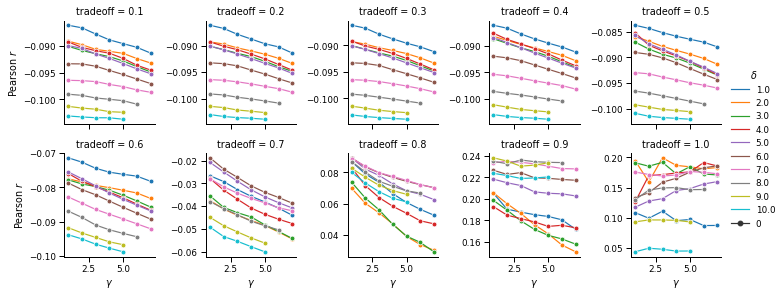

In [31]:
# calculate correlations
corrs = pd.DataFrame(index=np.arange(coco_growth.shape[1]), columns=['delta', 'gamma', 'tradeoff', 'corr', 'pval'])
i = 0
idx = np.array(np.isnan(exp_growth))
for c in coco_growth.columns:
    corrs.loc[i, ['delta', 'gamma', 'tradeoff']] = list(c)
    if sum(coco_growth.loc[:, c].isna()) == 0:
        corrs.loc[i, ['corr']], corrs.loc[i, ['pval']] = pearsonr(exp_growth[~idx], coco_growth.loc[~idx, c])
    i += 1

# format data
corrs['delta'] = np.round(pd.to_numeric(corrs['delta']), 2)
corrs['gamma'] = np.round(pd.to_numeric(corrs['gamma']), 2)
corrs['tradeoff'] = np.round(pd.to_numeric(corrs['tradeoff']), 1)
corrs['corr'] = pd.to_numeric(corrs['corr'])
corrs['delta'] = corrs['delta'].astype('category')

# grid of line plots
plt.clf()
sns.set_context("paper")
g = sns.relplot(data=corrs, x='gamma', y='corr', col='tradeoff', hue='delta', style=[0]*corrs.shape[0], kind='line', \
    col_wrap=min(5, len(np.unique(coco_growth.columns.get_level_values(2)))), height=2, aspect=1., markers='o', facet_kws={'sharey': False})
#g.axes[0].set_xscale('log')
g.set_xlabels(r'$\gamma$')
g.set_ylabels(r'Pearson $r$')
g._legend.set_title(r'$\delta$')

Extract parameters yielding the best correlations

Co-GEM vs CoCo-GEM: 0.00018360210399825938
Co-GEM vs METRADE: 0.9923635087303286
CoCo-GEM vs METRADE: 0.00013085462933171144


<Figure size 432x288 with 0 Axes>

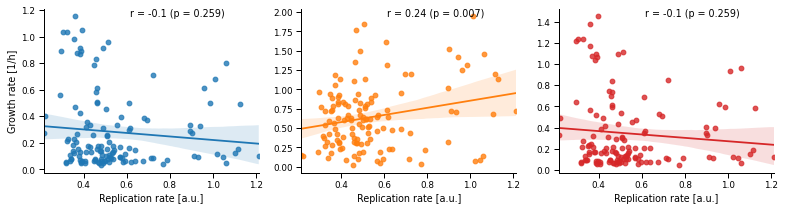

In [46]:
def dependent_corr(xy, xz, yz, n, twotailed=True, conf_level=0.95, method='steiger'):
    """
    Calculates the statistic significance between two dependent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between x and z
    @param yz: correlation coefficient between y and z
    @param n: number of elements in x, y and z
    @param twotailed: whether to calculate a one or two tailed test, only works for 'steiger' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'steiger' or 'zou'
    @return: t and p-val
    https://github.com/psinger/CorrelationStats
    https://cran.r-project.org/web/packages/cocor/cocor.pdf
    """
    if method == 'steiger':
        d = xy - xz
        determin = 1 - xy * xy - xz * xz - yz * yz + 2 * xy * xz * yz
        av = (xy + xz)/2
        cube = (1 - yz) * (1 - yz) * (1 - yz)

        t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
        p = 1 - t.cdf(abs(t2), n - 3)

        if twotailed:
            p *= 2

        return t2, p

# determine the best correlations
base_corrs = pd.DataFrame(index=['pearsonr','pvalue'], columns=base_growth.columns)
coco_corrs = pd.DataFrame(index=['pearsonr','pvalue'], columns=coco_growth.columns)
metrade_corrs = pd.DataFrame(index=['pearsonr','pvalue'], columns=metrade_growth.columns)
idx = np.array(np.isnan(exp_growth)) #np.logical_or(np.isnan(exp_growth), np.reshape(np.isnan(base_growth.iloc[:, 0].values), (135,1))))
for c in base_growth.columns:
    if sum(base_growth.loc[:, c].isna()) == 0:
        base_corrs.loc[:, c] = pearsonr(exp_growth[~idx], base_growth.loc[~idx, c])
for c in coco_growth.columns:
    if sum(coco_growth.loc[:, c].isna()) == 0:
        coco_corrs.loc[:, c] = pearsonr(exp_growth[~idx], coco_growth.loc[~idx, c])
for c in metrade_growth.columns:
    if sum(metrade_growth.loc[:, c].isna()) == 0:
        metrade_corrs.loc[:, c] = pearsonr(exp_growth[~idx], metrade_growth.loc[~idx, c])
best_base_idx = pd.to_numeric(base_corrs.loc['pearsonr']).idxmax()
best_coco_idx = pd.to_numeric(coco_corrs.loc['pearsonr']).idxmax()
best_metrade_idx = pd.to_numeric(metrade_corrs.loc['pearsonr']).idxmax()
best_corrs = [base_corrs.loc['pearsonr', best_base_idx], \
    coco_corrs.loc['pearsonr', best_coco_idx], \
    metrade_corrs.loc['pearsonr', best_metrade_idx]]
best_pvals = [base_corrs.loc['pvalue', best_base_idx], \
    coco_corrs.loc['pvalue', best_coco_idx], \
    metrade_corrs.loc['pvalue', best_metrade_idx]]

# format data
plot_data = pd.DataFrame(data={'Replication rate [a.u.]': np.squeeze(np.vstack((exp_growth, exp_growth, exp_growth))), \
    'Growth rate [1/h]': np.hstack((base_growth.loc[:, best_base_idx], coco_growth.loc[:, best_coco_idx], metrade_growth.loc[:, best_metrade_idx])), \
    'Models': np.array(['Co-GEM']*len(exp_growth) + ['CoCo-GEM']*len(exp_growth) + ['METRADE']*len(exp_growth))})
plot_data['Models'] = plot_data['Models'].astype('category')
_, pval_coco_vs_base = dependent_corr(best_corrs[0], best_corrs[1], pearsonr(base_growth.loc[~idx, best_base_idx], coco_growth.loc[~idx, best_coco_idx])[0], \
    len(exp_growth), twotailed=True, method='steiger')
_, pval_metrade_vs_base = dependent_corr(best_corrs[0], best_corrs[2], pearsonr(base_growth.loc[~idx, best_base_idx], metrade_growth.loc[~idx, best_metrade_idx])[0], \
    len(exp_growth), twotailed=True, method='steiger')
_, pval_coco_vs_metrade = dependent_corr(best_corrs[1], best_corrs[2], pearsonr(coco_growth.loc[~idx, best_coco_idx], metrade_growth.loc[~idx, best_metrade_idx])[0], \
    len(exp_growth), twotailed=True, method='steiger')
print('Co-GEM vs CoCo-GEM: ' + str(pval_coco_vs_base))
print('Co-GEM vs METRADE: ' + str(pval_metrade_vs_base))
print('CoCo-GEM vs METRADE: ' + str(pval_coco_vs_metrade))
colors = {'Co-GEM': 'tab:blue', 'CoCo-GEM': 'tab:orange', 'METRADE': 'tab:red'}

# grid of scatter plots
plt.cla()
plt.clf()
sns.set_context("paper")
p = sns.lmplot(data=plot_data, x='Replication rate [a.u.]', y='Growth rate [1/h]', col='Models', hue='Models', \
    height=3, aspect=1.2, sharey=False, palette=colors)
models = ['Co-GEM', 'CoCo-GEM', 'METRADE']
for i in range(len(p.axes[0])):
    ax = p.axes[0][i]
    ax.set_title('')
    ax.text(.4, .95, f"r = {str(np.around(best_corrs[i], 2))} (p = {str(np.around(best_pvals[i], 3))})", transform=ax.transAxes)

Calculate the full flux solutions for the best parameter combination

In [ ]:
base_fluxes, coco_fluxes, base_exchanges, coco_exchanges = compute_fluxes(float(best_base_idx[2]), \
    float(best_coco_idx[0]), float(best_coco_idx[1]), float(best_coco_idx[2]), False, True)
base_fluxes.to_csv(results_dir + 'base_fluxes_noBiogas.csv')
coco_fluxes.to_csv(results_dir + 'coco_fluxes_noBiogas.csv')
base_exchanges.to_csv(results_dir + 'base_exchanges_noBiogas.csv')
coco_exchanges.to_csv(results_dir + 'coco_exchanges_noBiogas.csv')

Also with METRADE

In [ ]:
_, metrade_fluxes, _, metrade_tot_exchanges = compute_fluxes(float(best_base_idx[2]), \
    float(best_metrade_idx[0]), float(best_metrade_idx[1]), float(best_metrade_idx[2]), False, False)
metrade_fluxes.to_csv(results_dir + 'metrade_fluxes_noBiogas.csv')
metrade_tot_exchanges.to_csv(results_dir + 'metrade_tot_exchanges_noBiogas.csv')

Or else, load pre-calculated results if already saved

In [12]:
base_fluxes = pd.read_table(results_dir + 'base_fluxes_noBiogas.csv', sep=',', \
    index_col=['Unnamed: 0', 'compartment'])
coco_fluxes = pd.read_table(results_dir + 'coco_fluxes_noBiogas.csv', sep=',', \
    index_col=['Unnamed: 0', 'compartment'])
metrade_fluxes = pd.read_table(results_dir + 'metrade_fluxes_noBiogas.csv', sep=',', \
    index_col=['Unnamed: 0', 'compartment'])
base_exchanges = pd.read_table(results_dir + 'base_exchanges_noBiogas.csv', sep=',', \
    index_col='Unnamed: 0')
coco_exchanges = pd.read_table(results_dir + 'coco_exchanges_noBiogas.csv', sep=',', \
    index_col='Unnamed: 0')
metrade_tot_exchanges = pd.read_table(results_dir + 'metrade_exchanges_noBiogas.csv', sep=',', \
    index_col='Unnamed: 0')

Check out the biogas production rates

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BH vs. SAH: t-test paired samples, P_val:7.962e-01 t=2.944e-01
BH vs. AH: t-test paired samples, P_val:2.482e-04 t=-6.346e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BH vs. SAH: t-test paired samples, P_val:6.740e-01 t=4.876e-01
BH vs. AH: t-test paired samples, P_val:2.395e-01 t=-1.656e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BH vs. SAH: t-test paired samples, P_val:2.915e-02 t=-5.729e+00
BH vs. AH: t-test paired samples, P_val:4.675e-02 t=-4.461e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5

<Figure size 432x288 with 0 Axes>

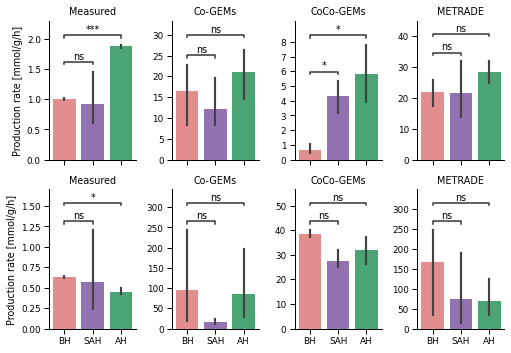

In [47]:
from statannotations.Annotator import Annotator

plot_data = pd.DataFrame(data={'Flux': \
    np.hstack((biochemistry_table.loc['ch4', :], biochemistry_table.loc['co2', :], \
        base_exchanges.loc['EX_ch4_e_m', :], base_exchanges.loc['EX_co2_e_m', :], \
        coco_exchanges.loc['EX_ch4_e_m', :], coco_exchanges.loc['EX_co2_e_m', :], \
        metrade_tot_exchanges.loc['EX_ch4_e_m', :], metrade_tot_exchanges.loc['EX_co2_e_m', :])), \
    'Method': 18*['Measured'] + 18*['Co-GEMs'] + 18*['CoCo-GEMs'] + 18*['METRADE'], \
    'Compound': 4*(9*['Methane'] + 9*['Carbon dioxide']), \
    'Condition': 8*list(np.repeat(['BH', 'SAH', 'AH'], 3))})
colors = {'BH': 'lightcoral', 'SAH': 'tab:purple', 'AH': 'mediumseagreen'}

# bar plot
plt.cla()
plt.clf()
sns.set_context("paper")
p = sns.catplot(x="Condition", y="Flux", row='Compound', col="Method", data=plot_data, \
    kind='bar', palette=colors, height=2.5, aspect=0.7, sharey=False)
p.set_xlabels('')
p.set_ylabels('Production rate [mmol/g/h]')
for i in range(2):
    p.axes[i][0].set_title('Measured')
    p.axes[i][1].set_title('Co-GEMs')
    p.axes[i][2].set_title('CoCo-GEMs')
    p.axes[i][3].set_title('METRADE')
p.axes[0][0].set_ylim((0, 2.0))
p.axes[0][2].set_yticks(np.arange(0, 9.0))

# add statistical comparisons
for i in range(2):
    for j in range(4):
        args = dict(x="Condition", y="Flux", data=plot_data.loc[np.logical_and(plot_data['Compound']==['Methane', 'Carbon dioxide'][i], \
            plot_data['Method']==p.axes[i][j].get_title()), :])
        annotator = Annotator(p.axes[i][j], [('BH','SAH'), ('BH','AH')], **args)
        annotator.configure(test='t-test_paired',  text_format='star', loc='inside')
        annotator.apply_test().annotate()

## Application

Parameter exloration, this time using the biogas production data

In [ ]:
deltas = np.arange(1., 9.)
gammas = np.arange(1., 8.)
tradeoffs = np.round(np.arange(0.8, 1.05, 0.1), 1) # cooperative tradeoff fraction
base_growth, coco_growth, _, _ = parameter_exploration(deltas, gammas, tradeoffs, True, True)
base_growth.to_csv(results_dir + 'base_growths.csv')
coco_growth.to_csv(results_dir + 'coco_growths.csv')

Again, pre-calculated data can also be loaded

In [24]:
base_growth = pd.read_table(results_dir + 'base_growths.csv', sep=',', \
    index_col=[0,1], header=[0,1,2])
coco_growth = pd.read_table(results_dir + 'coco_growths.csv', sep=',', \
    index_col=[0,1], header=[0,1,2])
exp_growth = np.array(pd.read_table(results_dir + 'exp_growths.csv', sep=',', \
    index_col='Unnamed: 0'))

Calculate the full flux solutions using the best parameters

In [ ]:
base_corrs = pd.DataFrame(index=['pearsonr','pvalue'], columns=base_growth.columns)
coco_corrs = pd.DataFrame(index=['pearsonr','pvalue'], columns=coco_growth.columns)
idx = np.array(np.isnan(exp_growth))
for c in coco_growth.columns:
    if sum(base_growth.loc[:, c].isna()) == 0:
        base_corrs.loc[:, c] = pearsonr(exp_growth[~idx], base_growth.loc[~idx, c])
    if sum(coco_growth.loc[:, c].isna()) == 0:
        coco_corrs.loc[:, c] = pearsonr(exp_growth[~idx], coco_growth.loc[~idx, c])
best_base_idx = pd.to_numeric(base_corrs.loc['pearsonr']).idxmax()
best_coco_idx = pd.to_numeric(coco_corrs.loc['pearsonr']).idxmax()

base_fluxes, coco_fluxes, base_exchanges, coco_exchanges = compute_fluxes(float(best_base_idx[0]), \
    float(best_coco_idx[0]), float(best_coco_idx[1]), float(best_coco_idx[2]), True)
base_fluxes.to_csv(results_dir + 'base_fluxes.csv')
coco_fluxes.to_csv(results_dir + 'coco_fluxes.csv')
base_exchanges.to_csv(results_dir + 'base_exchanges.csv')
coco_exchanges.to_csv(results_dir + 'coco_exchanges.csv')

Or re-load the results if already saved

In [12]:
base_fluxes = pd.read_table(results_dir + 'base_fluxes.csv', sep=',', \
    index_col=['Unnamed: 0', 'compartment'])
coco_fluxes = pd.read_table(results_dir + 'coco_fluxes.csv', sep=',', \
    index_col=['Unnamed: 0', 'compartment'])
base_exchanges = pd.read_table(results_dir + 'base_exchanges.csv', sep=',', \
    index_col='Unnamed: 0')
coco_exchanges = pd.read_table(results_dir + 'coco_exchanges.csv', sep=',', \
    index_col='Unnamed: 0')
abundances = pd.read_table(results_dir + 'abundances.csv', sep=',', \
    index_col='Unnamed: 0')
abundances.index = base_fluxes.index
abundances = abundances.div(abundances.sum(axis=0, level=0), axis=0, level=0)

Clean values to account for machine solver precision

In [27]:
base_fluxes[base_fluxes.abs() < 1e-6] = 0
coco_fluxes[coco_fluxes.abs() < 1e-6] = 0
base_exchanges[base_exchanges.abs() < 1e-6] = 0
coco_exchanges[coco_exchanges.abs() < 1e-6] = 0

Rename bins with taxa names

In [ ]:
taxa = ['Aneurinibacillaceae sp.', 'Firmicutes sp. 2', 'Acetivibrionaceae sp.', \
    'Bacteroidales sp. 1', 'Limnochordia sp. 2', 'C. proteolyticus', \
    'Bacteroidales sp. 2', 'Methanothermobacter sp.', 'Firmicutes sp. 1', \
    'Firmicutes sp. 3', 'Lutisporaceae sp.', 'Methanobacterium sp.', \
    'Competibacteraceae sp.', 'Firmicutes sp. 6', 'Acetomicrobium sp. 2', \
    'Acetomicrobium flavidum', 'Methanosarcina sp.', 'Tepidiphilus sp.', \
    'Defluviitoga tunisiensis', 'Firmicutes sp. 7', 'Oscillospirales sp. 2', \
    'Methanoculleus sp.', 'Firmicutes sp. 5', 'Thermodesulfovibrio sp.', 'Acetomicrobium sp. 1', \
    'Oscillospirales sp. 1', 'Firmicutes sp. 4', 'Limnochordia sp. 1']
MAG_dict = pd.Series(taxa, index=['bin_10_operams', 'bin_10_unicycler', 'bin_13_unicycler',
    'bin_15_metaspades', 'bin_15_operams', 'bin_16_metaspades',
    'bin_19_unicycler', 'bin_23_metaspades', 'bin_24_unicycler',
    'bin_25_unicycler', 'bin_26_metaspades', 'bin_26_operams',
    'bin_2_unicycler', 'bin_31_metaspades', 'bin_35_metaspades',
    'bin_36_metaspades', 'bin_37_operams', 'bin_43_metaspades',
    'bin_4_operams', 'bin_50_metaspades', 'bin_51_operams',
    'bin_57_operams', 'bin_58_operams', 'bin_5_unicycler', 'bin_64_operams',
    'bin_7_metaspades', 'bin_7_unicycler', 'bin_9_metaspades'])
index = pd.MultiIndex.from_tuples(list(zip(coco_fluxes.index.get_level_values(0), MAG_dict[coco_fluxes.index.get_level_values(1)])))
base_fluxes.index = index
coco_fluxes.index = index

Various preliminary operations

In [ ]:
# define indeces
BH_idx = coco_fluxes.index.get_level_values(0).isin(sample_names[0:3])
SAH_idx = coco_fluxes.index.get_level_values(0).isin(sample_names[3:6])
AH_idx = coco_fluxes.index.get_level_values(0).isin(sample_names[6:9])
# multiply fluxes by the corresponding MAG abundance to get the total exchange fluxes
base_cum_fluxes = base_fluxes.mul(np.tile(abundances, (1, base_fluxes.shape[1])))
coco_cum_fluxes = coco_fluxes.mul(np.tile(abundances, (1, coco_fluxes.shape[1])))
# get mean abundance
mean_abundance = abundance_table.mean(axis=1)
mean_abundance = mean_abundance.loc[mean_abundance.index.isin(MAG_dict.index)]
mean_abundance.index = MAG_dict.loc[mean_abundance.index]

Metabolic exchange PCA

<Figure size 432x288 with 0 Axes>

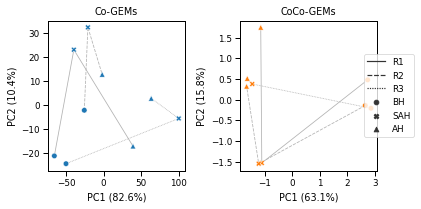

In [28]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scale(base_exchanges.replace(np.nan, 0).T, with_std=False))
base_pca_transform = pca.transform(scale(base_exchanges.replace(np.nan, 0).T, with_std=False))
base_explained = pca.explained_variance_ratio_
base_components = pca.components_.T
pca.fit(scale(coco_exchanges.replace(np.nan, 0).T, with_std=False))
coco_pca_transform = pca.transform(scale(coco_exchanges.replace(np.nan, 0).T, with_std=False))
coco_explained = pca.explained_variance_ratio_
coco_components = pca.components_.T
plot_data = pd.DataFrame(data={'PC1': np.hstack((base_pca_transform[:, 0], coco_pca_transform[:, 0])), \
    'PC2': np.hstack((base_pca_transform[:, 1], coco_pca_transform[:, 1])), \
    'Model': np.array(['Co-GEMs']*len(sample_names) + ['CoCo-GEMs']*len(sample_names)), \
    'Condition': np.hstack([['BH']*3 + ['SAH']*3 + ['AH']*3]*2), \
    'Reactor': ['R1', 'R2', 'R3']*6})
plot_data['Model'] = plot_data['Model'].astype('category')

# scatter plot
plt.cla()
plt.clf()
sns.set_context("paper")
colors = sns.color_palette(n_colors=2)
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.scatterplot(data=plot_data.loc[plot_data['Model']=='Co-GEMs', :], x='PC1', y='PC2', style='Condition', \
    markers={'BH':'o', 'SAH':'X', 'AH': '^'}, s=30, legend=False, ax=axes[0], zorder=2)
sns.scatterplot(data=plot_data.loc[plot_data['Model']=='CoCo-GEMs', :], x='PC1', y='PC2', style='Condition', \
    markers={'BH':'o', 'SAH':'X', 'AH': '^'}, color=colors[1], s=30, ax=axes[1], zorder=2)
sns.lineplot(data=plot_data.loc[plot_data['Model']=='Co-GEMs', :], x='PC1', y='PC2', style='Reactor', color=[.7, .7, .7], \
    lw=0.8, legend=False, ax=axes[0], zorder=1, sort=False)
sns.lineplot(data=plot_data.loc[plot_data['Model']=='CoCo-GEMs', :], x='PC1', y='PC2', style='Reactor', color=[.7, .7, .7], \
    lw=0.8, ax=axes[1], zorder=1, sort=False)
axes[0].set_title('Co-GEMs')
axes[0].set_xlabel('PC1 (' + str(np.round(100*base_explained[0], 1)) + '%)')
axes[0].set_ylabel('PC2 (' + str(np.round(100*base_explained[1], 1)) + '%)')
axes[1].set_title('CoCo-GEMs')
axes[1].set_xlabel('PC1 (' + str(np.round(100*coco_explained[0], 1)) + '%)')
axes[1].set_ylabel('PC2 (' + str(np.round(100*coco_explained[1], 1)) + '%)')
axes[1].legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.tight_layout()

Flux t-SNE

<Figure size 432x288 with 0 Axes>

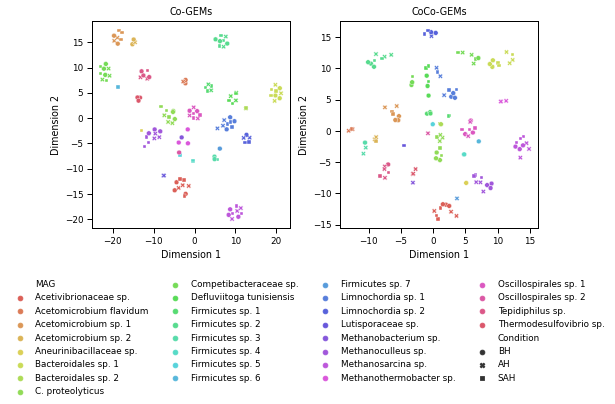

In [34]:
from sklearn.manifold import TSNE

num_cases = coco_fluxes.shape[0]
tsne = TSNE(n_components=2, init="random", random_state=0, perplexity=20, n_iter=5000)
base_Y = tsne.fit_transform(base_fluxes.replace(np.nan, 0))
coco_Y = tsne.fit_transform(coco_fluxes.replace(np.nan, 0))
plot_data = pd.DataFrame(data={'Dim1': np.hstack((base_Y[:, 0], coco_Y[:, 0])), \
        'Dim2': np.hstack((base_Y[:, 1], coco_Y[:, 1])), \
        'Model': np.array(['Co-GEMs']*num_cases + ['CoCo-GEMs']*num_cases), \
        'Condition': np.hstack([['BH']*BH_idx.sum() + \
            ['SAH']*SAH_idx.sum() + \
            ['AH']*AH_idx.sum()]*2), \
        'MAG': list(MAG_dict[list(coco_fluxes.index.get_level_values(1))])*2})
plot_data['Model'] = plot_data['Model'].astype('category')
plot_data = plot_data.sort_values(by=['MAG'])

plt.clf()
sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
fig.subplots_adjust(bottom=0.4, wspace=0.25)
p1 = sns.scatterplot(data=plot_data.loc[plot_data['Model']=='Co-GEMs', :], x='Dim1', y='Dim2', hue='MAG', style='Condition', \
    palette=sns.color_palette("hls", 28), legend=False, ax=axes[0])
p2 = sns.scatterplot(data=plot_data.loc[plot_data['Model']=='CoCo-GEMs', :], x='Dim1', y='Dim2', hue='MAG', style='Condition', \
    palette=sns.color_palette("hls", 28), ax=axes[1])
axes[0].set_title('Co-GEMs')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')
axes[1].set_title('CoCo-GEMs')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False)
axes[1].get_legend().remove()

t-SNE with varying perplexity

<Figure size 432x288 with 0 Axes>

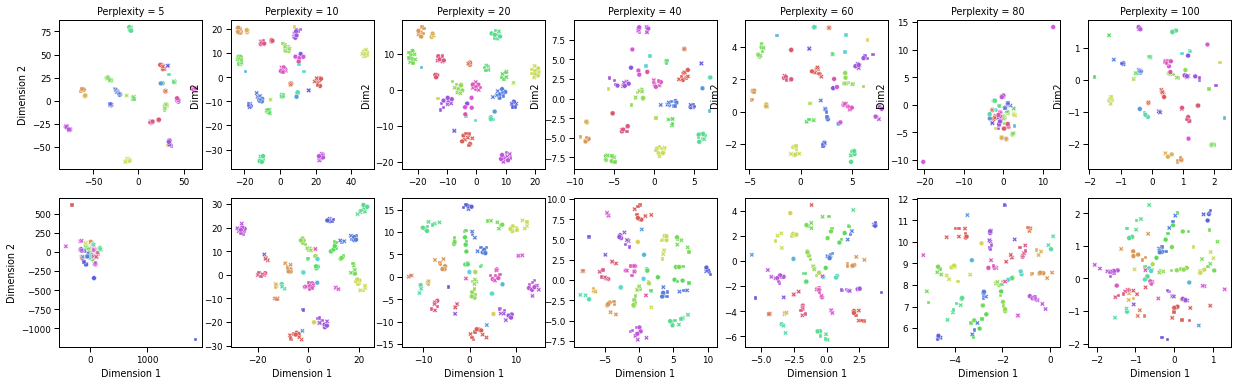

In [28]:
perplexities = [5, 10, 20, 40, 60, 80, 100]

plt.clf()
sns.set_context("paper")
fig, axes = plt.subplots(2, len(perplexities), figsize=(3*len(perplexities), 6))
for i in range(len(perplexities)):
    tsne = TSNE(n_components=2, init="random", random_state=0, perplexity=perplexities[i], n_iter=5000)
    base_Y = tsne.fit_transform(base_fluxes.replace(np.nan, 0))
    coco_Y = tsne.fit_transform(coco_fluxes.replace(np.nan, 0))
    plot_data = pd.DataFrame(data={'Dim1': np.hstack((base_Y[:, 0], coco_Y[:, 0])), \
            'Dim2': np.hstack((base_Y[:, 1], coco_Y[:, 1])), \
            'Model': np.array(['Co-GEMs']*num_cases + ['CoCo-GEMs']*num_cases), \
            'Condition': np.hstack([['BH']*coco_fluxes.index.get_level_values(0).isin(BH).sum() + \
                ['SAH']*coco_fluxes.index.get_level_values(0).isin(SAH).sum() + \
                ['AH']*coco_fluxes.index.get_level_values(0).isin(AH).sum()]*2), \
            'MAG': list(MAG_dict[list(coco_fluxes.index.get_level_values(1))])*2})
    plot_data['Model'] = plot_data['Model'].astype('category')
    plot_data = plot_data.sort_values(by=['MAG'])

    p1 = sns.scatterplot(data=plot_data.loc[plot_data['Model']=='Co-GEMs', :], x='Dim1', y='Dim2', hue='MAG', style='Condition', \
        palette=sns.color_palette("hls", 28), legend=False, ax=axes[0][i])
    p2 = sns.scatterplot(data=plot_data.loc[plot_data['Model']=='CoCo-GEMs', :], x='Dim1', y='Dim2', hue='MAG', style='Condition', \
        palette=sns.color_palette("hls", 28), legend=False, ax=axes[1][i])
    axes[0][i].set_title('Perplexity = ' + str(perplexities[i]))
    axes[0][i].set_xlabel('')
    axes[1][i].set_xlabel('Dimension 1')
    axes[1][i].set_ylabel('')

axes[0][0].set_ylabel('Dimension 2')
axes[1][0].set_ylabel('Dimension 2')

Calculate Silhouette coefficients

2.5372897953185752e-20


<Figure size 432x288 with 0 Axes>

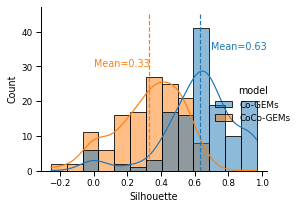

In [42]:
# silhouette coefficients
from sklearn.metrics import silhouette_samples

base_sil = silhouette_samples(base_fluxes.fillna(0).values, base_fluxes.index.get_level_values(1))
coco_sil = silhouette_samples(coco_fluxes.fillna(0).values, coco_fluxes.index.get_level_values(1))
sil_plot_df = pd.DataFrame({'Silhouette': np.hstack([base_sil, coco_sil]), 'model': ['Co-GEMs']*135+['CoCo-GEMs']*135})
base_mean = np.mean(sil_plot_df.loc[sil_plot_df['model']=='Co-GEMs', 'Silhouette'])
coco_mean = np.mean(sil_plot_df.loc[sil_plot_df['model']=='CoCo-GEMs', 'Silhouette'])
base_max = np.max(sil_plot_df.loc[sil_plot_df['model']=='Co-GEMs', 'Silhouette'])
coco_max = np.max(sil_plot_df.loc[sil_plot_df['model']=='CoCo-GEMs', 'Silhouette'])

plt.cla()
plt.clf()
sns.set_context("paper")
p = sns.displot(data=sil_plot_df, x='Silhouette', hue='model', kde=True, height=3, aspect=1.)
plt.plot([base_mean, base_mean], [0, 45], color='tab:blue', linestyle='dashed')
plt.plot([coco_mean, coco_mean], [0, 45], color='tab:orange', linestyle='dashed')
plt.text(0.7, 35, 'Mean='+str(np.round(base_mean, 2)), {'color': 'tab:blue'})
plt.text(0, 30, 'Mean='+str(np.round(coco_mean, 2)), {'color': 'tab:orange'})
plt.tight_layout()

from scipy.stats import wilcoxon
stat, pval = wilcoxon(base_sil, coco_sil)
print(pval)


Check the division of methane production

/home/bioinfo/bin/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


<Figure size 432x288 with 0 Axes>

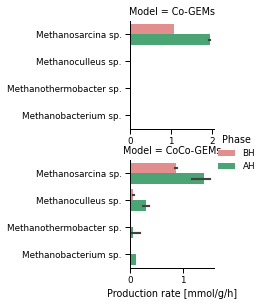

In [16]:
archaea = ['Methanosarcina sp.', 'Methanoculleus sp.', 'Methanobacterium sp.', 'Methanothermobacter sp.']
ch4_df = pd.DataFrame({'Phase': np.tile(['BH']*sum(BH_idx)+['AH']*sum(AH_idx), 2), \
    'MAG': np.concatenate((base_cum_fluxes.index.get_level_values(1)[np.logical_or(BH_idx, AH_idx)], coco_cum_fluxes.index.get_level_values(1)[np.logical_or(BH_idx, AH_idx)])),
    'Flux': base_cum_fluxes.loc[np.logical_or(BH_idx, AH_idx), 'EX_ch4_e'].to_list() + coco_cum_fluxes.loc[np.logical_or(BH_idx, AH_idx), 'EX_ch4_e'].to_list(),
    'Model': ['Co-GEMs']*2*sum(BH_idx)+['CoCo-GEMs']*2*sum(AH_idx)})
ch4_df = ch4_df.loc[ch4_df['MAG'].isin(archaea), :]
colors = {'BH': 'lightcoral', 'AH': 'mediumseagreen'}

plt.cla()
plt.clf()
sns.set_context("paper")
p = sns.catplot(data=ch4_df, x='Flux', y='MAG', hue='Phase', hue_order=['BH','AH'], row='Model', orient='h', \
    kind='bar', palette=colors, height=2., aspect=0.9, sharex=False)
p.set_xlabels('Production rate [mmol/g/h]')
p.set_ylabels('')

Sankey-like producer-metabolite diagram

In [ ]:
import plotly.graph_objects as go

plot_mets = pd.Series(['ac', 'co2', 'h2', 'ch4'], index=['Acetate', 'Carbon dioxide', 'Hydrogen', 'Methane'])
plot_df = coco_cum_fluxes.loc[np.logical_or(BH_idx, AH_idx), 'EX_'+plot_mets+'_e'].sum(level=1).dropna(axis=1, how='all')
plot_df_BH = coco_cum_fluxes.loc[BH_idx, 'EX_'+plot_mets+'_e'].sum(level=1).dropna(axis=1, how='all')
plot_df_AH = coco_cum_fluxes.loc[AH_idx, 'EX_'+plot_mets+'_e'].sum(level=1).dropna(axis=1, how='all')
plot_df.shape

plot_MAGs = pd.Series(plot_df.index.unique())
plot_abundances = pd.Series(mean_abundance.loc[plot_MAGs])
plot_MAGs = plot_MAGs.iloc[plot_abundances.argsort()[::-1]]

producers = ['Environment']*3
metabolites = ['Acetate', 'Acetate', 'Hydrogen']
counts = [np.abs(plot_df_BH['EX_ac_e'].sum()), np.abs(plot_df_AH['EX_ac_e'].sum()), np.abs(plot_df_AH['EX_h2_e'].sum())]
colors = [0, 1, 1]
for m1 in plot_MAGs:
    for m2 in plot_mets:
        # BH
        if m1 in plot_df_BH.index:
            flux = plot_df_BH.loc[m1, 'EX_'+m2+'_e']
            if flux > 0:
                producers.append(m1)
                metabolites.append(plot_mets.index[plot_mets==m2][0])
                counts.append(flux)
                colors.append(0)
        # AH
        if m1 in plot_df_AH.index:
            flux = plot_df_AH.loc[m1, 'EX_'+m2+'_e']
            if flux > 0:
                producers.append(m1)
                metabolites.append(plot_mets.index[plot_mets==m2][0])
                counts.append(flux)
                colors.append(1)

colorscale = [[0, 'lightcoral'], [1, 'mediumseagreen']]

fig = go.Figure(go.Parcats(
    dimensions=[
        {'label': 'Producer',
         'values': producers},
        {'label': 'Metabolite',
         'values': metabolites}],
    counts=counts,
    line={'color': colors, 'colorscale': colorscale},
    labelfont={'size': 12, 'family': 'Arial'},
    tickfont={'size': 8, 'family': 'Arial'}),
    go.Layout(margin=dict(t=1, b=3)))
left_height = len(np.unique(producers))
print(sum(counts))

fig.update_layout(width=400, height=400)
fig.show()

43.98607955116945


Sankey-like metabolite-recipient diagram

In [ ]:
plot_mets = pd.Series(['ac', 'co2', 'h2', 'ch4'], index=['Acetate', 'Carbon dioxide', 'Hydrogen', 'Methane'])
plot_df = coco_cum_fluxes.loc[np.logical_or(BH_idx, AH_idx), 'EX_'+plot_mets+'_e'].sum(level=1).dropna(axis=1, how='all')
plot_df_BH = coco_cum_fluxes.loc[BH_idx, 'EX_'+plot_mets+'_e'].sum(level=1).dropna(axis=1, how='all')
plot_df_AH = coco_cum_fluxes.loc[AH_idx, 'EX_'+plot_mets+'_e'].sum(level=1).dropna(axis=1, how='all')
plot_df.shape

plot_MAGs = pd.Series(plot_df.index.unique())
plot_abundances = pd.Series(mean_abundance.loc[plot_MAGs])
plot_MAGs = plot_MAGs.iloc[plot_abundances.argsort()[::-1]]

recipients = []
metabolites = []
counts = []
colors = []
for m1 in plot_MAGs:
    for m2 in plot_mets:
        # BH
        if m1 in plot_df_BH.index:
            flux = plot_df_BH.loc[m1, 'EX_'+m2+'_e']
            if flux < 0:
                recipients.append(m1)
                metabolites.append(plot_mets.index[plot_mets==m2][0])
                counts.append(np.abs(flux))
                colors.append(0)
        # AH
        if m1 in plot_df_AH.index:
            flux = plot_df_AH.loc[m1, 'EX_'+m2+'_e']
            if flux < 0:
                recipients.append(m1)
                metabolites.append(plot_mets.index[plot_mets==m2][0])
                counts.append(np.abs(flux))
                colors.append(1)
recipients = recipients + ['Environment']*4
metabolites = metabolites + ['Carbon dioxide', 'Carbon dioxide', 'Methane', 'Methane']
counts = counts + [np.abs(plot_df_BH['EX_co2_e'].sum()), np.abs(plot_df_AH['EX_co2_e'].sum()), \
    np.abs(plot_df_BH['EX_ch4_e'].sum()), np.abs(plot_df_AH['EX_ch4_e'].sum())]
colors = colors + [0, 1, 0, 1]

colorscale = [[0, 'lightcoral'], [1, 'mediumseagreen']]

fig = go.Figure(go.Parcats(
    dimensions=[
        {'label': 'Metabolite',
         'values': metabolites},
        {'label': 'Recipient',
         'values': recipients}],
    counts=counts,
    line={'color': colors, 'colorscale': colorscale},
    labelfont={'size': 12, 'family': 'Arial'},
    tickfont={'size': 8, 'family': 'Arial'}),
    go.Layout(margin=dict(t=2, b=2)))
right_height = len(np.unique(recipients))
print(sum(counts))

fig.update_layout(width=400, height=400*1.1)
fig.show()

43.986076056668566


Cluster amino acid exchanges

/home/bioinfo/bin/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/home/bioinfo/bin/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


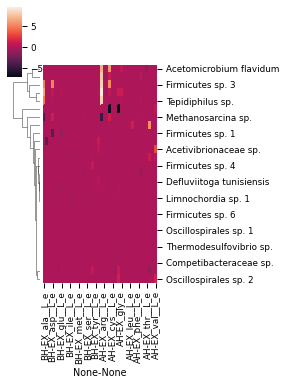

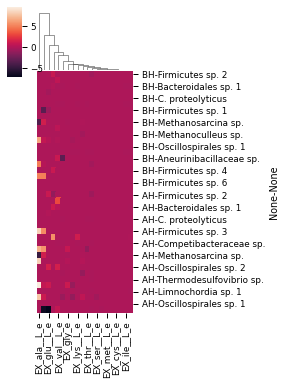

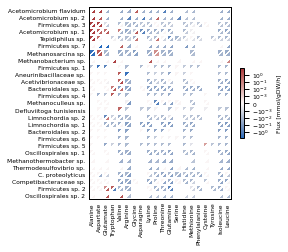

In [ ]:
from matplotlib.tri import Triangulation
from matplotlib.colors import SymLogNorm

def triangulation_for_biheatmap(M, N):
    x = np.arange(M + 1)
    y = np.arange(N + 1)
    xs, ys = np.meshgrid(x, y)
    x = xs.ravel()
    y = ys.ravel()
    triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [triangles1, triangles2]]

aa_rxns = ['EX_ala__L_e', \
    'EX_arg__L_e',
    'EX_asn__L_e',
    'EX_asp__L_e',
    'EX_cys__L_e',
    'EX_gln__L_e',
    'EX_glu__L_e',
    'EX_gly_e',
    'EX_his__L_e',
    'EX_ile__L_e',
    'EX_leu__L_e',
    'EX_lys__L_e',
    'EX_met__L_e',
    'EX_phe__L_e',
    'EX_pro__L_e',
    'EX_ser__L_e',
    'EX_thr__L_e',
    'EX_trp__L_e',
    'EX_tyr__L_e',
    'EX_val__L_e']
AA_dict = pd.Series(['Alanine',
    'Arginine',
    'Asparagine',
    'Aspartate',
    'Cysteine',
    'Glutamine',
    'Glutamate',
    'Glycine',
    'Histidine',
    'Isoleucine',
    'Leucine',
    'Lysine',
    'Methionine',
    'Phenylalanine',
    'Proline',
    'Serine',
    'Threonine',
    'Tryptophan',
    'Tyrosine',
    'Valine'], index=aa_rxns)

# set up data frames
plot_df_BH = coco_fluxes.loc[BH_idx, aa_rxns].mean(level=1)
plot_df_AH = coco_fluxes.loc[AH_idx, aa_rxns].mean(level=1)
plot_df_hor = pd.concat([plot_df_BH, plot_df_AH], axis=1, keys=['BH', 'AH'])
plot_df_ver = pd.concat([plot_df_BH, plot_df_AH], axis=0, keys=['BH', 'AH'])

# make dendrograms
p = sns.clustermap(plot_df_hor.fillna(0), col_cluster=False, method='complete', metric='euclidean', figsize=(4, 4*2.7/2))
row_idx = p.dendrogram_row.reordered_ind
p = sns.clustermap(plot_df_ver.fillna(0), row_cluster=False, method='complete', metric='euclidean', figsize=(4, 4*2.7/2))
col_idx = p.dendrogram_col.reordered_ind

# reorder rows and columns
plot_df_hor = plot_df_hor.iloc[row_idx, np.concatenate((col_idx, np.array(col_idx)+len(col_idx)))]

# get triangle data
M = len(plot_df_hor.columns) // 2
N = len(plot_df_hor)
triangul = triangulation_for_biheatmap(M, N)
values = [plot_df_hor[i] for i in ['BH', 'AH']]
cmaps = ['vlag'] * 2

# plot double heatmap
fig, ax = plt.subplots(figsize=(4, 4*2.7/2))
imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=SymLogNorm(1e-3, base=10, vmin=plot_df_hor.min().min(), vmax=plot_df_hor.max().max()), ec='white') \
    for t, val, cmap, in zip(triangul, values, cmaps)]

ax.tick_params(length=0)
ax.set_xticks(np.arange(M)+0.8)
ax.set_xticklabels([AA_dict[a] for a in plot_df_hor['BH'].columns], fontsize=6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.set_yticks(np.arange(N)+0.5)
ax.set_yticklabels(plot_df_hor.index, fontsize=6)
ax.invert_yaxis()
ax.margins(x=0, y=0)
ax.set_aspect('equal', 'box')  # square cells
cbar = plt.colorbar(imgs[0], ax=ax, shrink=0.2, ticks=[-10**i for i in range(-3, 2)]+[0]+[10**i for i in range(-3, 2)], \
    )
cbar.ax.tick_params(labelsize=6)
cbar.set_label(label='Flux [mmol/gDW/h]', size=6)
plt.tight_layout()